In [194]:
using LinearAlgebra
using Flux
using DiffEqFlux
using OrdinaryDiffEq
using GalacticOptim
using Plots
using Zygote
using BenchmarkTools
using CUDA
using Printf

include("src/equations/initial_functions.jl")
include("src/equations/equations.jl")
include("src/utils/graphic_tools.jl")
include("src/utils/generators.jl")
include("src/utils/processing_tools.jl")
include("src/neural_ode/objectives.jl")
include("src/neural_ode/models.jl")

Main.Models

# Analytical solution

Compute the analytical solution u(t, x) and the analytical derivative by time of the solution u(t,x)

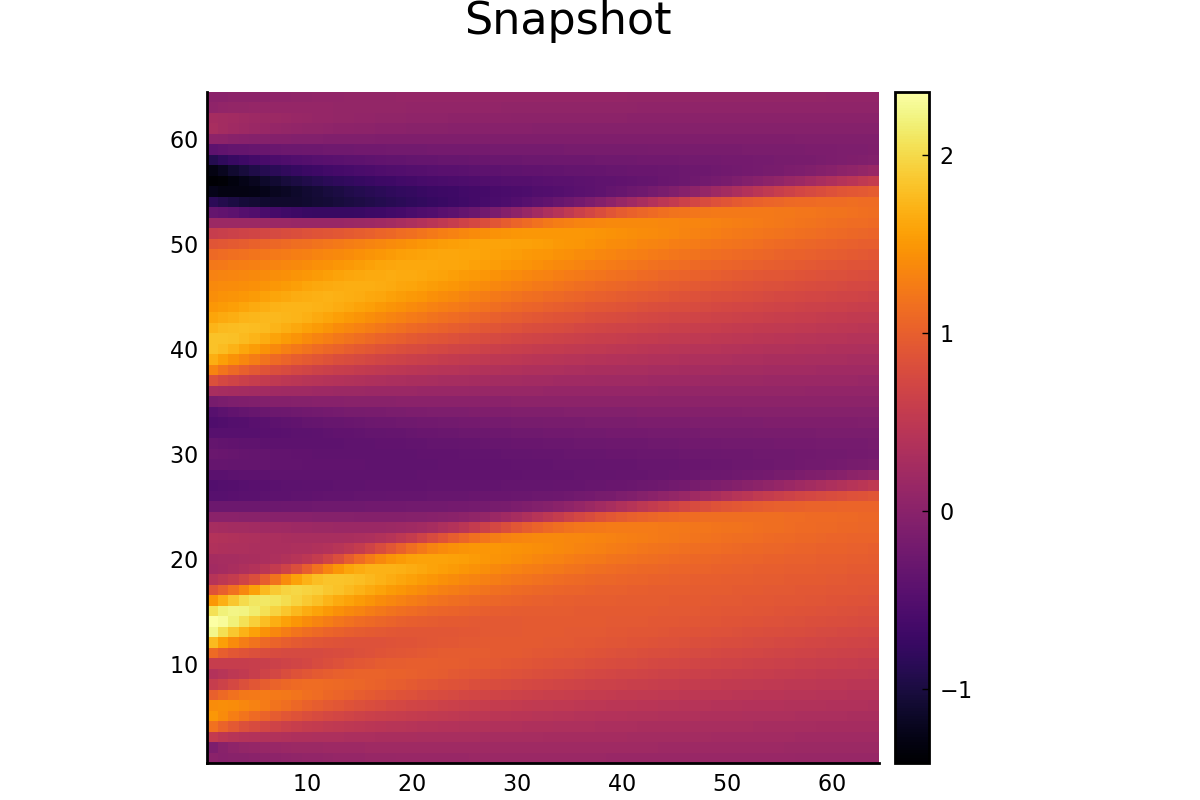

In [4]:
t_max = 0.2;
t_min = 0.;
x_max = 1.;
x_min = 0.;
t_n = 64;
x_n = 64;

nu = 0.01;

dt = round((t_max - t_min) / (t_n - 1), digits=8);
dx = round((x_max - x_min) / (x_n - 1), digits=8);

t = LinRange(t_min, t_max, t_n);
x = LinRange(x_min, x_max, x_n);

u0 = InitialFunctions.high_dim_random_init(t, x);
t, u = Equations.get_burgers_fft(t, dx, x_n, nu, u0[1, :]);
GraphicTools.show_state(u, "Snapshot") # need to reverse u, odesolver switch dimensions

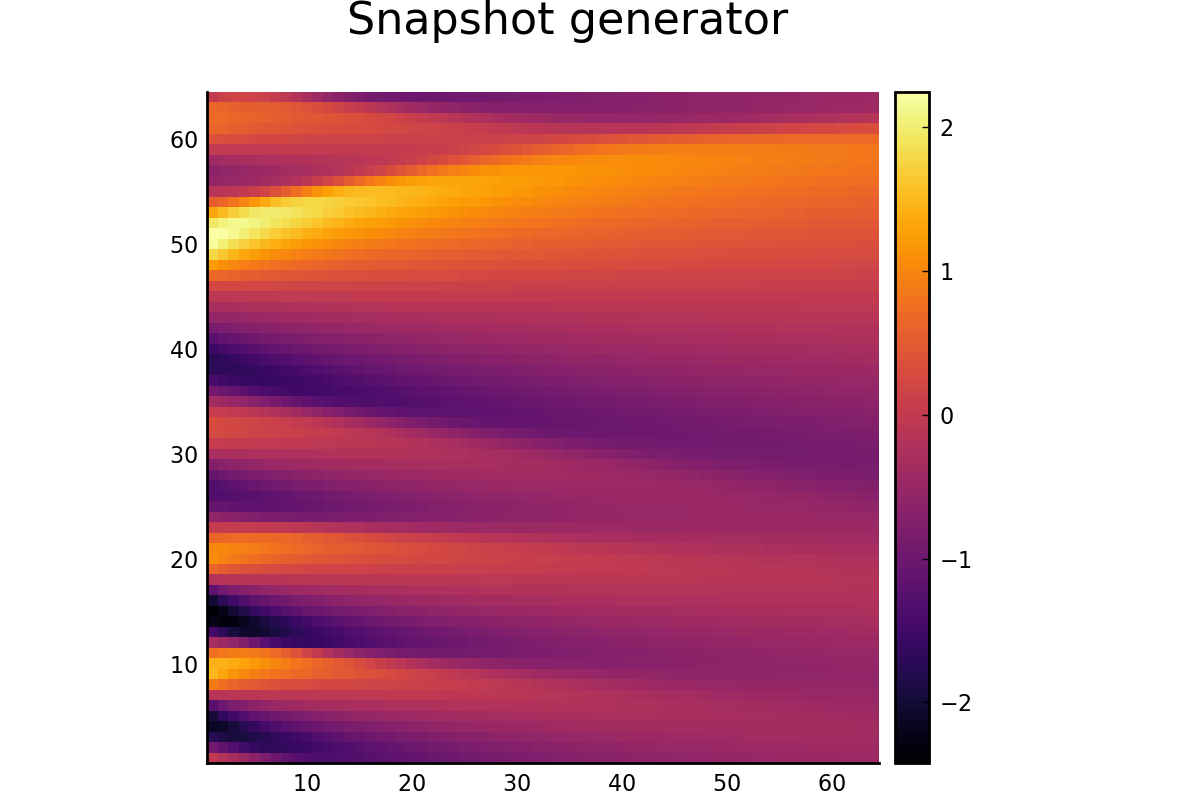

In [5]:
ta, u_a = Generator.burgers_snapshot_generator(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
GraphicTools.show_state(u_a, "Snapshot generator")

In [7]:
dataset = Generator.generate_burgers_training_dataset(t_max, t_min, x_max, x_min, t_n, x_n, nu, 64, 2, 1, false, "./src/dataset/burgers_high_dim_training_set.jld2", "training_set");
high_dataset = Generator.read_dataset("./src/dataset/burgers_high_dim_training_set.jld2")["training_set"];
# coarse_dataset = Generator.read_dataset("./src/dataset/burgers_coarse_training_set.jld2")["training_set"];

Item1Item2Item3Item4Item5Item6Item7Item8Item9Item10Item11Item12Item13Item14Item15Item16Item17Item18Item19Item20Item21Item22Item23Item24Item25Item26Item27Item28Item29Item30Item31Item32Item33Item34Item35Item36Item37Item38Item39Item40Item41Item42Item43Item44Item45Item46Item47Item48Item49Item50Item51Item52Item53Item54Item55Item56Item57Item58Item59Item60Item61Item62Item63Item64

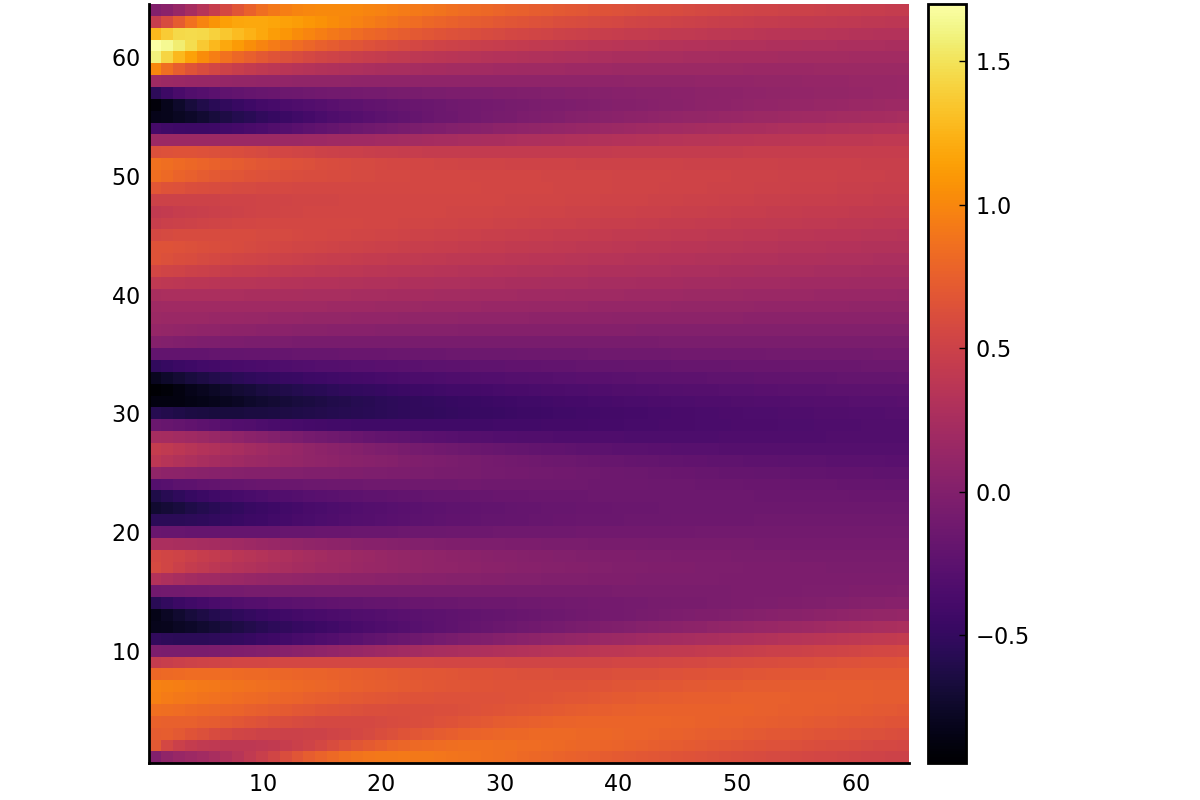

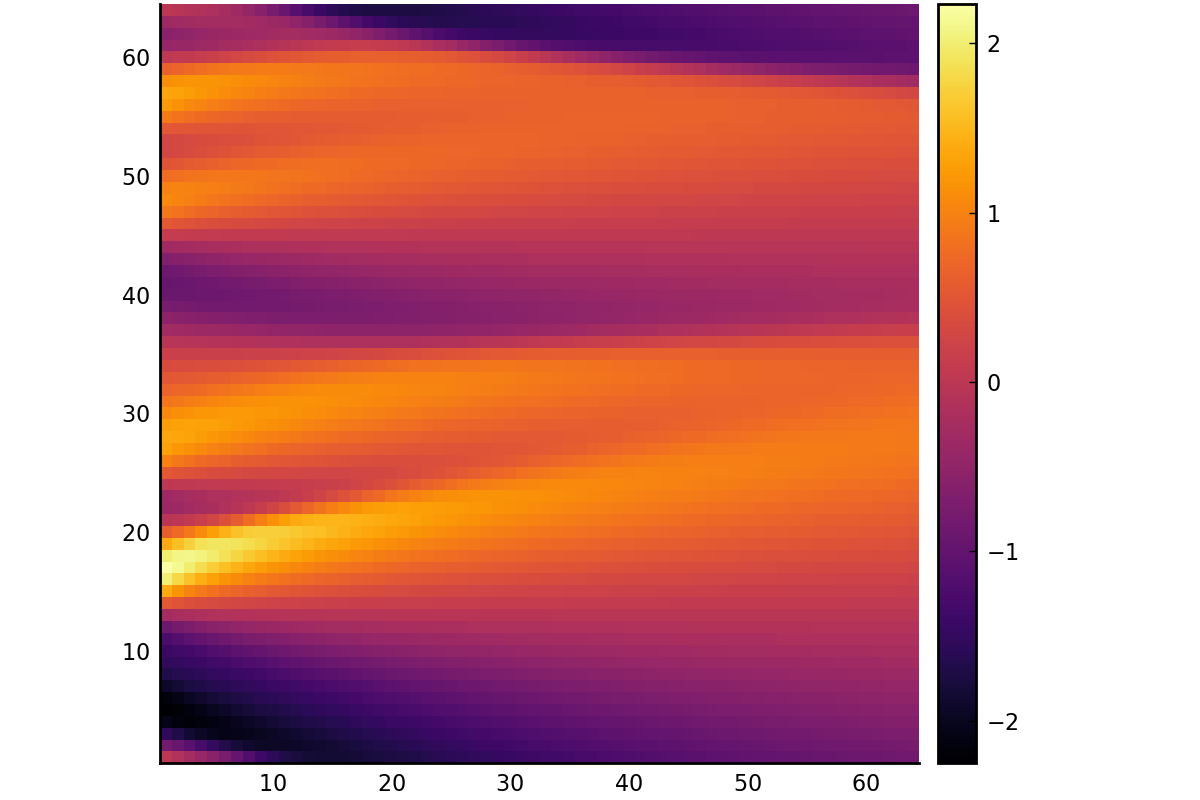

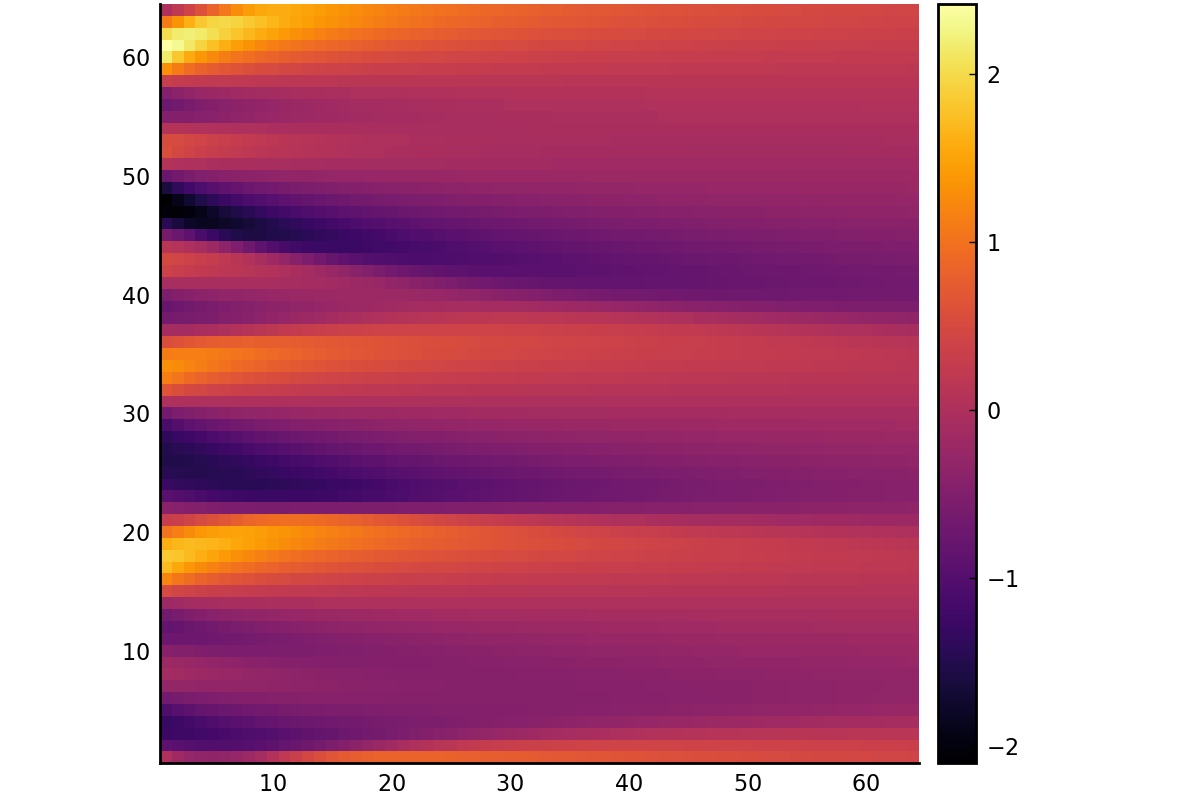

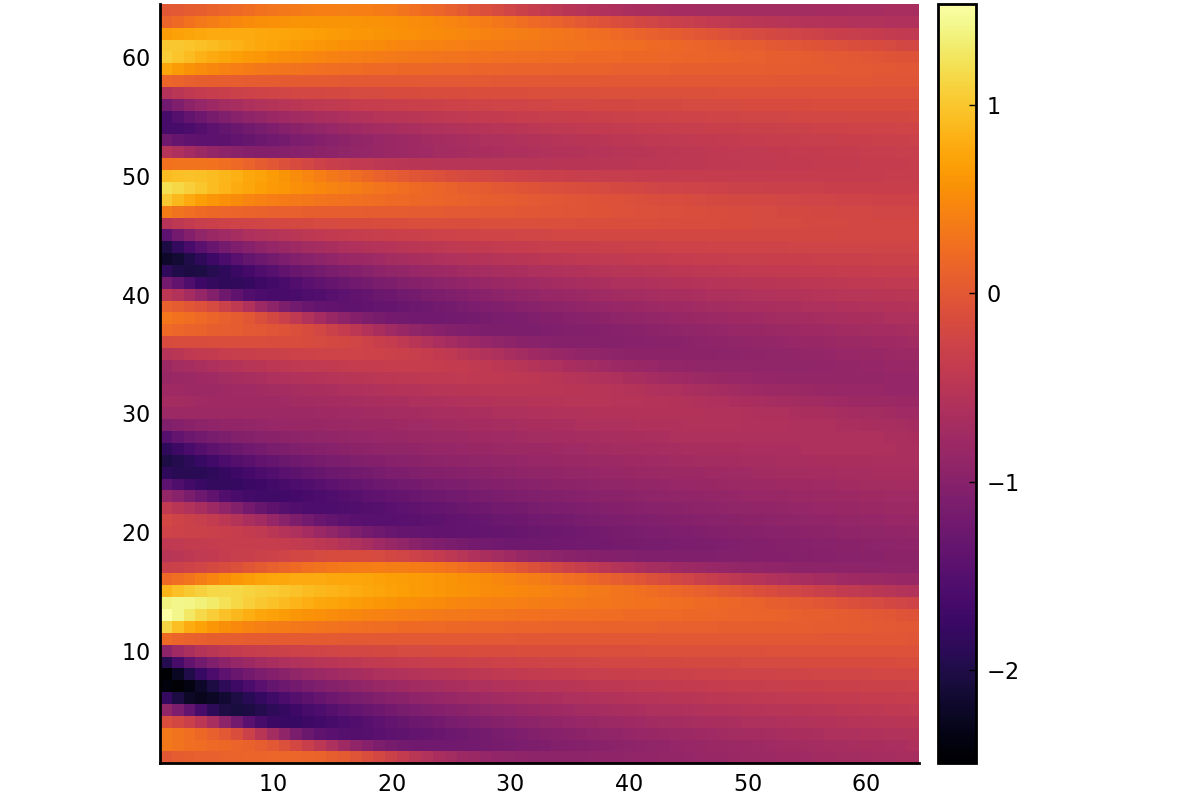

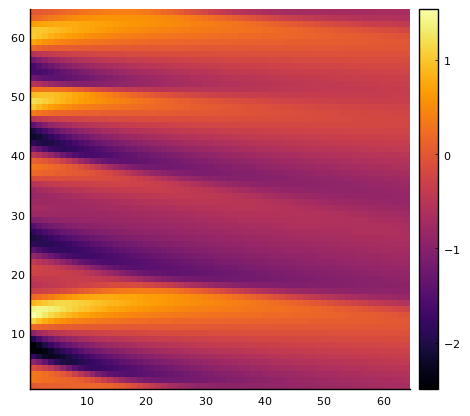

In [8]:
function check_training_dataset(dataset)
    for i in range(1, 4, step=1)
        a, b = dataset[i];
        display(GraphicTools.show_state(b, ""))
    end
end

check_training_dataset(high_dataset)

# Training with NeuralODE object

In [184]:
callback(theta, loss, u) = (display(loss); false)

callback (generic function with 1 method)

In [370]:
function burgers_training(net, epochs, u0, u_true, t)
  optimizer = DiffEqFlux.ADAM(0.03, (0.9, 0.999), 1.0e-8)
  
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode(theta)
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode(theta)
    noise = 1e-6 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  return result
end

burgers_training (generic function with 2 methods)

In [144]:
function check_result(nn, res, typ)
    t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
    prob_neuralode = DiffEqFlux.NeuralODE(nn, (t[1], t[end]), Tsit5(), saveat=t)
    u_pred = prob_neuralode(u0, res)

    plot(
        GraphicTools.show_state(u, ""),
        GraphicTools.show_state(hcat(u_pred.u...), ""),
        GraphicTools.show_err(hcat(u_pred.u...), u, "");
        layout = (1, 3),
    )
end

check_result (generic function with 1 method)

## Experiment with different models

### Heat linear model

In [371]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 2, init_set, true_set, t);

0.576222172150511

0.5225261137127347

0.5225261137127347

In [178]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net = Models.HeatModel(x_n);
result = burgers_training(net, 100, init_set, true_set, t);

0.09595138726848176

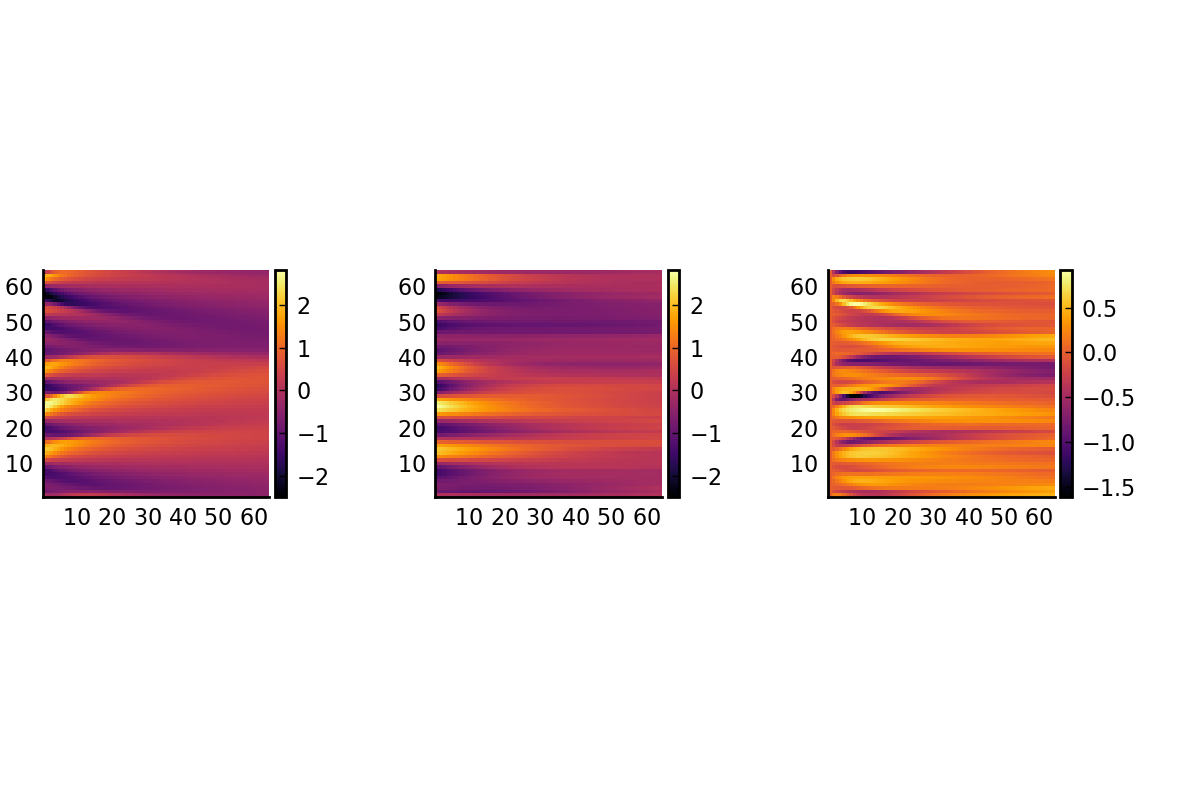

In [166]:
K = reshape(result, (x_n, x_n))
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));  # S function at bottom of notebook

plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, ""),
    GraphicTools.show_state((u_pred .- u), "");
    layout = (1, 3),
)

##### Operator reconstructed

Visualize reconstructed operator and check efficiency to determine solution from unknown sample

In [19]:
function f(u, K, t)
  return K * u
end

function S(net, u0, t)
  tspan = (t[1], t[end])
  prob = ODEProblem(ODEFunction(f), copy(u0), tspan, net)
  sol = solve(prob, Tsit5(), saveat=t, reltol=1e-8, abstol=1e-8)
end

S (generic function with 1 method)

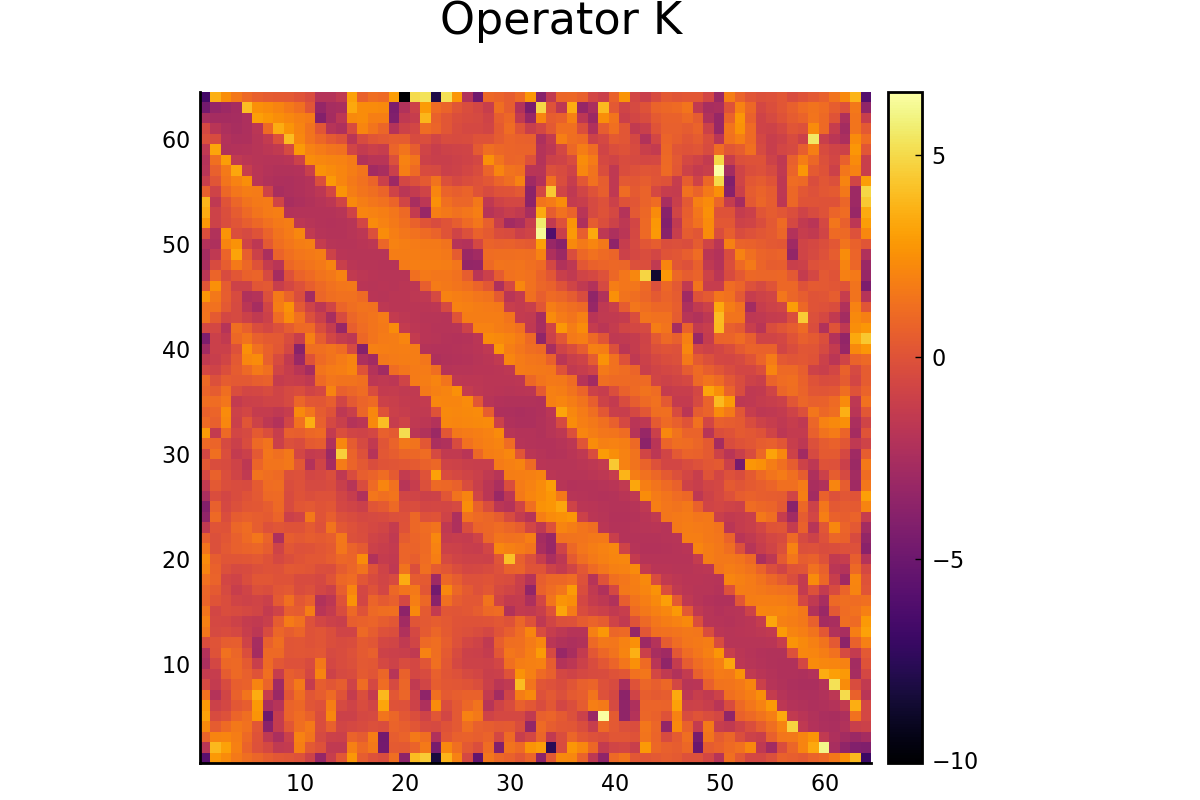

In [170]:
K = reshape(result, (x_n, x_n))
GraphicTools.show_state(reverse(K; dims = 1), "Operator K")

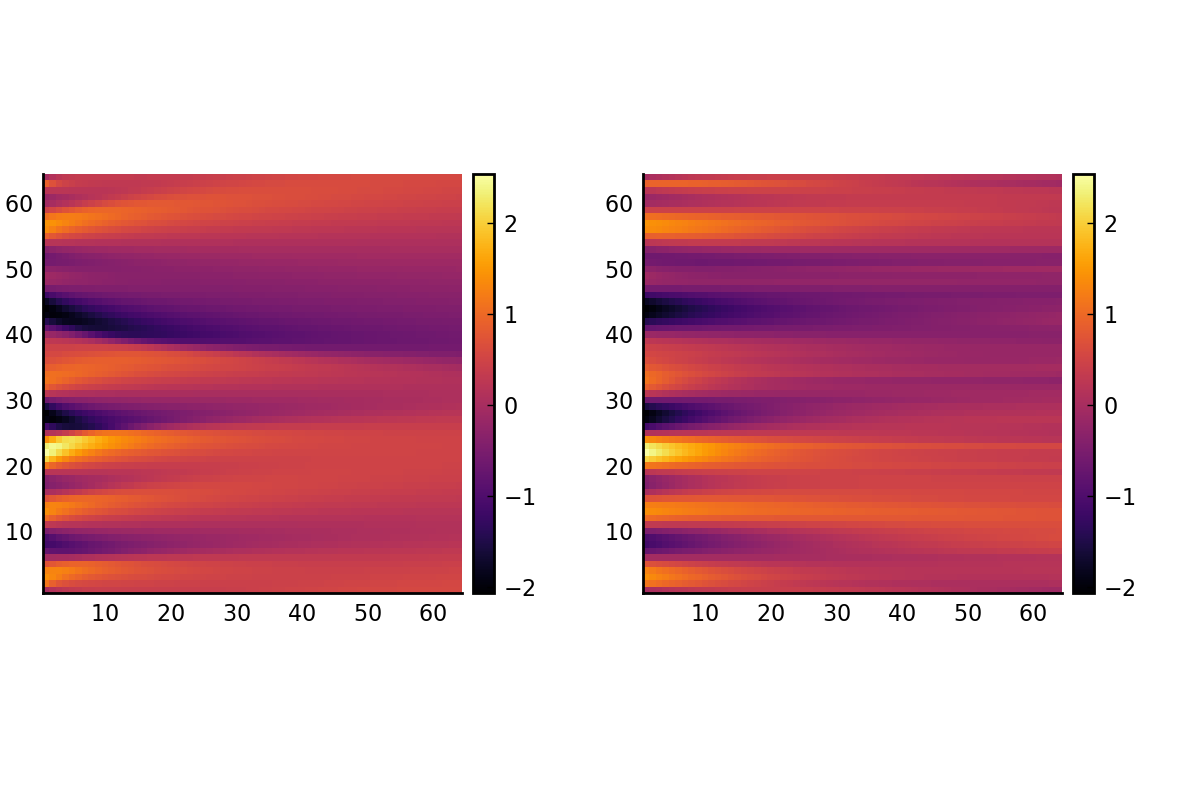

In [172]:
t, u0, u = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, 2);
u_pred = Array(S(K, u0, t));
plot(
    GraphicTools.show_state(u, ""),
    GraphicTools.show_state(u_pred, "");
    layout = (1, 2),
)

--- 
### FNN

In [163]:
# t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
net2 = Models.BasicFNN(x_n);
result2 = burgers_training(net2, 100, init_set, true_set, t);

0.024155279815646233

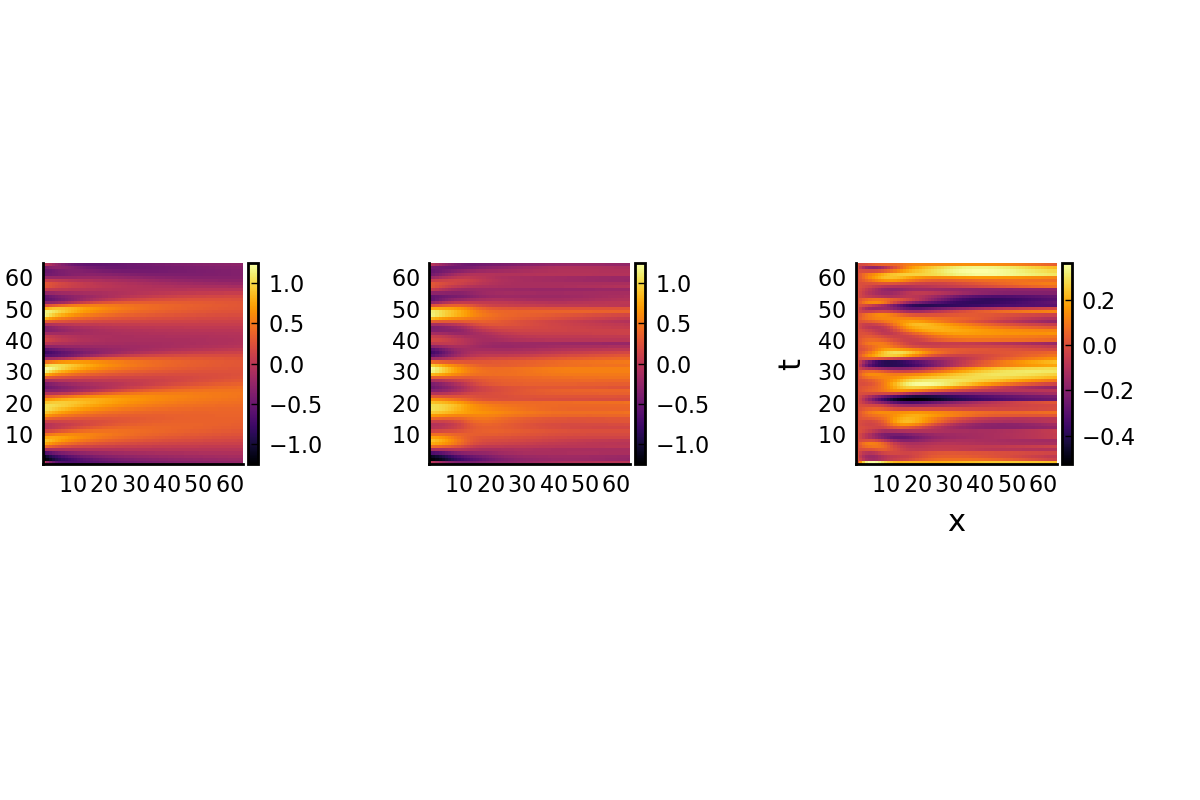

In [168]:
check_result(net2, result2, 2)

### Basic Autoencoder

In [98]:
net3 = Models.BasicAutoEncoder(x_n);
result3 = burgers_training(net3, 1000, init_set, true_set, t);

0.01652838877194026

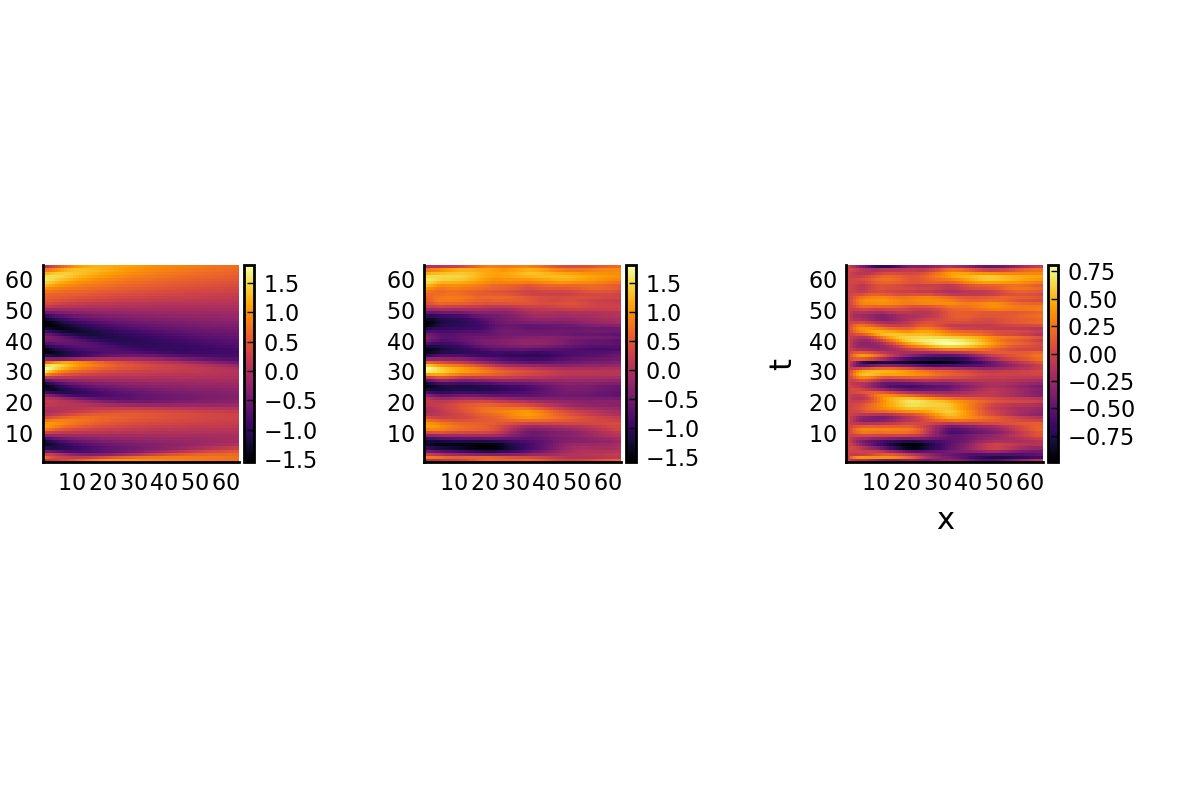

In [188]:
check_result(net3, result3, 2)

## Analysis

In [112]:
function test_simulation(net, result, n, typ)
    mse_tot = 0
    l1_tot = 0
    for i in n
        t, u0, u_true = Generator.get_burgers_batch(t_max, t_min, x_max, x_min, t_n, x_n, nu, typ);
        prob_neuralode = DiffEqFlux.NeuralODE(net, (t[1], t[end]), Tsit5(), saveat=t)
        u_pred = prob_neuralode(u0, result)

        mse_tot += Objectives.mseloss(u_pred, u_true)
        l1_tot += sum(abs.(u_pred .- u_true))
    end
    
    return mse_tot / n, l1_tot / n
end

test_simulation (generic function with 2 methods)

In [128]:
println(test_simulation(net, result, 1000, 1))
println(test_simulation(net, result, 1000, 2))

(0.0002828624166032775, 1.5390019690418886)
(8.397219534904251e-5, 0.85276956569482)


In [129]:
println(test_simulation(net2, result2, 1000, 1))
println(test_simulation(net2, result2, 1000, 2))

(0.00011839169662328861, 1.0680877974366458)
(0.00016945239636424275, 1.2624593690008312)


In [130]:
println(test_simulation(net3, result3, 1000, 1))
println(test_simulation(net3, result3, 1000, 2))

(0.00022676439087168087, 1.5477461332282696)
(7.570743527656456e-5, 0.9148374862579417)


## Train 2

In [ ]:
function augment(data)
    noise = 1e-6 .* randn(size(u_pred))
    return data + noise
end

In [ ]:
function load_data(dataset)
    t, init_set, true_set = ProcessingTools.process_dataset(dataset, false);
    
    
    return none, none, none
end

In [ ]:
callback(theta, loss, u) = (display(loss); false)

In [ ]:
function train!(loss, ps::Params, data, opt::Flux.Optimise.AbstractOptimiser; cb = () -> ())
  call(f, xs...) = f(xs...)
  runall(f) = f
  runall(fs::AbstractVector) = () -> foreach(call, fs)
    
  cb = runall(cb)
  itrsz = Base.IteratorSize(typeof(data))
  n = (itrsz == Base.HasLength()) || (itrsz == Base.HasShape{1}()) ? length(data) : 0
  for (i, d) in enumerate(data)
    try
      gs = gradient(ps) do
        loss(d...)
      end
      update!(opt, ps, gs)
      cb()
    catch ex
      if ex isa Flux.Optimise.StopException
        break
      elseif ex isa Flux.Optimise.SkipException
        continue
      else
        rethrow(ex)
      end
    end
  end
end

In [332]:
function test_train(epochs, dataset)
    @info("Loading dataset")
    t, init_set, true_set = ProcessingTools.process_dataset(dataset, false);
    
    @info("Building model")
    # model = Chain(Dense(x_n => x_n, identity; bias=false, init=Flux.zeros32))
    model = HeatModel(x_n)
#     p, re = Flux.destructure(model)
#     K(u, p, t) = re(p)(u)

    tspan = (t[1], t[end])
    neural_ode = DiffEqFlux.NeuralODE(model, tspan, Tsit5(), saveat=t)
    ps = Flux.params(neural_ode.p)
    
    function predict_neural_ode(theta)
        return Array(neural_ode(init_set, theta))
    end
    
    function loss(theta)
        u_pred = predict_neural_ode(theta)
        l = Objectives.mseloss(augment(u_pred), u_true)
        return l, u_pred
    end
    
    optimizer = DiffEqFlux.ADAM(0.03, (0.9, 0.999), 1.0e-8)
    
    @info("Train")
    for e in 1:epochs
        DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = 1);
        # Flux.train!(loss, ps, true_set, optimizer; cb = callback)
        
    end
    
    acc = Objectives.mseloss(model(u0), u_true)
    @info(@sprintf("[%d]: Test accuracy: %.4f", e, acc))
    
    return model
end

test_train (generic function with 1 method)

In [345]:
function burgers_training2(epochs, dataset)
  @info("Loading dataset")
  t, u0, u_true = ProcessingTools.process_dataset(dataset, false);
  
  @info("Building model")
  net = Models.HeatModel(x_n)
  optimizer = DiffEqFlux.ADAM(0.03, (0.9, 0.999), 1.0e-8)
  tspan = (t[1], t[end])
  neural_ode = NeuralODE(net, tspan, Tsit5(), saveat=t)

  function predict_neural_ode()
    return Array(neural_ode(u0, theta))
  end

  function loss(theta)
    u_pred = predict_neural_ode()
    noise = 1e-6 .* randn(size(u_pred))
    l = Objectives.mseloss(u_pred + noise, u_true)
    return l, u_pred
  end

  @info("Train")
#   for e in 1:epochs
#     # ps = Flux.params(neural_ode.p)
#     ps = Flux.params(net)
#     Flux.train!(loss, ps, true_set, optimizer; cb = callback)
#   end
  # result = DiffEqFlux.sciml_train(loss, neural_ode.p, optimizer; cb = callback, maxiters = epochs);
  Flux.train!(loss, neural_ode.p, true_set, optimizer; cb = callback)
  return result
end

burgers_training2 (generic function with 1 method)

In [384]:
t, init_set, true_set = ProcessingTools.process_dataset(high_dataset, false);
# net = Models.HeatModel(x_n);
result = burgers_training2(2, high_dataset);

┌ Info: Loading dataset
└ @ Main In[345]:2
┌ Info: Building model
└ @ Main In[345]:5
┌ Info: Train
└ @ Main In[345]:22


LoadError: MethodError: no method matching train!(::var"#loss#583"{var"#predict_neural_ode#582"{NeuralODE{FastChain{Tuple{FastDense{typeof(identity), DiffEqFlux.var"#initial_params#96"{Vector{Float32}}, Nothing}}}, Vector{Float32}, Nothing, Tuple{Float64, Float64}, Tuple{Tsit5{typeof(OrdinaryDiffEq.trivial_limiter!), typeof(OrdinaryDiffEq.trivial_limiter!), Static.False}}, Base.Iterators.Pairs{Symbol, LinRange{Float64}, Tuple{Symbol}, NamedTuple{(:saveat,), Tuple{LinRange{Float64}}}}}, Matrix{Float64}}, Array{Float64, 3}}, ::Vector{Float32}, ::Array{Float64, 3}, ::ADAM; cb=callback)
[0mClosest candidates are:
[0m  train!(::Any, [91m::Params[39m, ::Any, ::Flux.Optimise.AbstractOptimiser; cb) at /Users/vdesgrange/.julia/packages/Flux/6Q5r4/src/optimise/train.jl:113

In [393]:
function test()
    t, u0, u_true = ProcessingTools.process_dataset(dataset, false);
    a = Chain(Dense(x_n => x_n, identity; init=Flux.zeros32));
    p, st = Flux.destructure(a);
    neural_ode = NeuralODE(a, (t[1], t[end]), Tsit5(), saveat=t);
    
    function predict_neural_ode()
      return Array(neural_ode(u0));
    end
    
    function loss(theta)
      u_pred = predict_neural_ode();
      noise = 1e-6 .* randn(size(u_pred));
      l = Objectives.mseloss(u_pred + noise, u_true);
      return l, u_pred
    end
    
    p = Flux.params(neural_ode.p);
    
    Flux.train!(loss, p, true_set, DiffEqFlux.ADAM(0.03); cb = callback);
    
    return neural_ode
end

res = test()

LoadError: MethodError: objects of type Vector{Float32} are not callable
Use square brackets [] for indexing an Array.